In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import skimage as sk
from skimage import transform
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

from utils import train_test_split


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def rotate_img(image):
    random_degree = random.uniform(-25, 25) #25% from left or right
    return sk.transform.rotate(image, random_degree)

def noise_img(image):
    return sk.util.random_noise(image)

In [3]:
with tf.Session() as sess:
    devices = sess.list_devices()
    for d in devices:
        print(d)

_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1544893621406747497)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4213455608090097078)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7900043239465411756)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 920715264, 14654280716635553963)


In [4]:
flooded_img = []
nonflooded_img = []
unlabeled_img = []

h_dim  = 1000
v_dim = 750

root = "Train"
flood_dir = os.path.join(root,'Labeled/Flooded/image/')
nonflood_dir = os.path.join(root,'Labeled/Non-Flooded/image/')
unlabel_dir = os.path.join(root,'Unlabeled/image/')

for file in os.listdir(flood_dir):
    image = Image.open(os.path.join(flood_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    flooded_img.append(rotate_img(image))

for file in os.listdir(nonflood_dir):
    image = Image.open(os.path.join(nonflood_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    nonflooded_img.append(rotate_img(image))
    
for file in os.listdir(unlabel_dir):
    image = Image.open(os.path.join(unlabel_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    unlabeled_img.append(rotate_img(image))
    unlabeled_img.append(rotate_img(image))

In [5]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))
print("Unlabeled Image Shape: {}".format(unlabeled_img[0].shape))

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)
Unlabeled Image Shape: (750, 1000, 3)


In [6]:
data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

(398, 750, 1000, 3)

In [7]:
unlabeled_img = np.array(unlabeled_img) /255.
unlabeled_img.shape

(374, 750, 1000, 3)

In [8]:
#train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
#test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()

test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
else:
    #n = 0 means all data is used!!!!
    n = 0
labele

idxs = train_test_split(flooded_img,nonflooded_img,unlabeled_img,n)
label_train_idx, label_test_idx, train_labels, test_labels, unlabel_train_idx, unlabel_test_idx = idxs

Data len 51; n is 51 ;train size 40, test size 11
Data len 347; n is 347 ;train size 277, test size 70
Training Indices len 317
Testing Indices len 81
Unlabelled Data len 374; n is 374 ;train size 277, test size 97
Unlabeled Training Index: [  0   1   2   4   5   7   8   9  10  11  12  13  18  19  22  23  24  26
  27  29  31  35  36  37  38  39  40  42  43  44  46  47  48  49  50  51
  52  54  55  56  59  60  61  62  63  67  68  69  70  71  73  74  76  78
  79  80  81  82  83  84  85  88  89  90  92  94  95  96  97  99 103 104
 105 106 108 110 111 112 114 115 116 117 118 119 120 122 123 124 126 127
 128 130 132 133 134 135 136 137 138 141 142 144 145 146 147 149 150 151
 152 155 156 157 158 159 161 165 167 169 170 171 172 173 174 175 176 179
 180 181 182 183 184 185 187 188 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 207 209 211 212 213 214 215 216 218 219 221 222 223
 224 225 226 227 228 229 230 231 232 233 235 236 238 241 242 244 245 246
 247 249 251 252 253 254 255 

### CNN CODE

In [9]:
# convolutional layer
def conv_layer(x, shape,stride):
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=stride, padding='VALID')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# sigmoid
sigmoid = lambda x: tf.nn.sigmoid(x)

# batch norm
batch_norm = lambda x: tf.layers.batch_normalization(x)

In [10]:
#shape = [filter_size, filter_size, num_input_channels, num_filters]

# define CNN
def toy_model(x,show_dim = False):
    
    # Six convolutional layers with max pool and ReLU
    
        #shape = [filter_size, filter_size, num_input_channels, num_filters]
    def conv_block(x,in_channels,out_channels, show_dim = False, stride = 2, kernel_h=10,kernel_w =10,):
        shape = [kernel_h,kernel_w,in_channels,out_channels]
        x = conv_layer(x, shape,stride)
        x = relu(x)
        x = batch_norm(x)
        x = max_pool(x, k=2)
        if show_dim:
            print(x.shape)
        return x
    
    x = conv_block(x,3,16,show_dim)

    x = conv_block(x,16,16,show_dim)
        
    x = conv_block(x,16,32,show_dim)
        
    #x = conv_block(x,32,64,show_dim)
    
    #x = conv_block(x,64,64,show_dim)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(x)
    print(flat1.shape)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)
    if show_dim:
        print(fc1.shape)

    fc2 = fully_connected_layer(fc1, [64, 1])
    if show_dim:
        print(fc2.shape)

    return fc2

In [11]:
def sharpen(p):
    
    T = 0.5
    pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
    return pred


def generate_guess_label(pred_u_raw, k):
    # guess label = average prediction over k augmentations of same image
    # num_images = pred_u_raw.shape[0].value / k # Throws error of NoneType and int since pred_u_raw.shape[0].value is None
    
    try:
        num_images = int(pred_u_raw.shape[0].value / k)

        idx = 0
        temp_labels = []
        for i in range(num_images):
            temp_labels.append(tf.reduce_mean(pred_u_raw[idx:idx+k]))
            idx += k

        # repeat label for each augmentation
        guess_labels = tf.repeat(tf.stack(temp_labels), k)

        # reshape and remove gradient tracking
        guess_labels = tf.reshape(guess_labels, (-1,1))
        guess_labels = tf.stop_gradient(guess_labels)

        return guess_labels

    except TypeError:
      
      return pred_u_raw

In [16]:
# define inputs
hdim = data_img[0].shape[0]
vdim = data_img[0].shape[1]
x = tf.placeholder(tf.float32, [None, hdim, vdim, 3], 'x') # labeled images (augmented)
u = tf.placeholder(tf.float32, [None, hdim, vdim, 3], 'u') # unlabeled images (augmented)
y = tf.placeholder(tf.float32, [None, 1], 'y') # labels
train_labels = np.array(train_labels).reshape(-1,1)
test_labels = np.array(test_labels).reshape(-1,1)
k = 2 # augment images k times

# Google paper section 3.5 says 100 is a good place to start for w_unlabeled
# Google paper also suggests ramping up value to 100 over first 16,000 epochs
w_unlabeled = 100. 

# run model with placeholder tensors (feed forward pass)
pred_x = toy_model(x)
pred_u_raw = toy_model(u)
pred_u_raw = sigmoid(pred_u_raw)

# calculate guess labels for unlabeled images 
pred_u = generate_guess_label(pred_u_raw, k) # average predictions across same unlabelled images

# sharpen guess labels 
pred_u = sharpen(pred_u)

# define loss
cross_entropy = tf.losses.sigmoid_cross_entropy(logits=pred_x, multi_class_labels=y)
labeled_loss = tf.reduce_mean(cross_entropy)
unlabeled_loss = tf.nn.l2_loss(pred_u - pred_u_raw)
cost = labeled_loss + w_unlabeled*unlabeled_loss

# define accuracy
pred_u_class = tf.round(pred_u_raw)
pred_x_class = tf.round(sigmoid(pred_x))
pred_correct = tf.equal(pred_x_class, tf.cast(y, tf.float32))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 200
batch_size = 4 #len(train_idx)

## Train Model

In [17]:
# train model
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    best_acc = 0.
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(label_train_idx)//batch_size

    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
        train_labeled_results = []
        train_unlabeled_results = []
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[label_train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size, len(label_train_idx))]
            batch_u = unlabeled_img[unlabel_train_idx,:,:,:][batch*k*batch_size:min((batch+1)*k*batch_size, len(unlabel_train_idx))]
            batch_y = train_labels[batch*batch_size:min((batch+1)*batch_size, len(train_labels))]

            feed_dict={x: batch_x, u: batch_u, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc, pred_x_labels, pred_u_labels  = sess.run([cost, accuracy, pred_x_class, pred_u_class], 
                                                                feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc
            train_labeled_results.append(pred_x_labels)
            train_unlabeled_results.append(pred_u_labels)

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches
        

        # Calculate accuracy for all test images
        valid_loss, test_acc, test_labeled_results, test_unlabeled_results = sess.run([cost, accuracy, pred_x_class, pred_u_class],
                                feed_dict={x: data_img[label_test_idx,:,:,:], u: unlabeled_img[unlabel_test_idx,:,:,:], y : test_labels})
        
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        if test_acc > best_acc:
            best_model_train_labeled = tf.stack(tf.reshape(tf.stack(train_labeled_results),[-1,1])).eval()
            best_model_train_unlabeled = tf.stack(tf.reshape(tf.stack(train_unlabeled_results),[-1,1])).eval()
            best_model_test_labeled = test_labeled_results
            best_model_test_unlabeled = test_unlabeled_results
            best_acc = test_acc
        
        if i%10 == 0:
            print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(ave_acc) + ", Testing Accuracy= " + \
                  "{:.5f}".format(test_acc))

    summary_writer.close()

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D_30 (defined at /home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'Conv2D_30':
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
    user_expressions, allow_stdin,
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2887, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2932, in _run_cell
    return runner(coro)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3156, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3347, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-e9bf34b77e76>", line 17, in <module>
    pred_u_raw = toy_model(u)
  File "<ipython-input-10-11a64cbcda42>", line 8, in toy_model
    conv0 = conv_layer(x, shape0)
  File "<ipython-input-9-e055cf063474>", line 7, in conv_layer
    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_ops.py", line 2010, in conv2d
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p37/gpu_cuda10.0/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


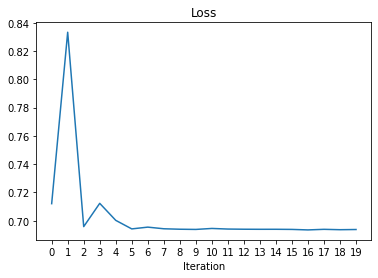

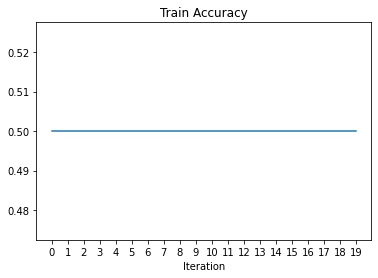

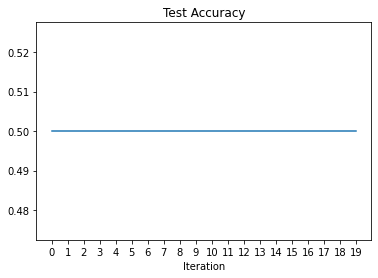

In [86]:
for title, data in {"Loss": train_loss,"Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}.items():
    plt.plot(data)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.show()